In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ner-dataset/ner_datasetreference.csv


In [2]:
data = pd.read_csv('/kaggle/input/ner-dataset/ner_datasetreference.csv', encoding='latin1')

In [3]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data = data.fillna(method='ffill')

In [5]:
entities_to_remove = ["B-gpe","I-gpe","B-tim","I-tim","B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
data = data[~data.Tag.isin(entities_to_remove)]
data =data.drop(['POS'],axis=1)
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [6]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [7]:
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        agg_function = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.group = self.data.groupby('Sentence #').apply(agg_function)
        self.sentence = [s for s in self.group]

In [8]:
getter = GetSentence(data)

In [9]:
sentence = [[word[0] for word in sentence] for sentence in getter.sentence]

In [10]:
sentence[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [11]:
labels = [[lab[1] for lab in sentence] for sentence in getter.sentence]

In [12]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [13]:
tag_values = list(set(data["Tag"].values))

In [14]:
tag_values

['B-per', 'I-geo', 'I-per', 'B-org', 'I-org', 'B-geo', 'O']

In [15]:
tag_values.append('PAD')

In [16]:
tag_idx = {t: i for i, t in enumerate(tag_values)}

In [17]:
tag_idx

{'B-per': 0,
 'I-geo': 1,
 'I-per': 2,
 'B-org': 3,
 'I-org': 4,
 'B-geo': 5,
 'O': 6,
 'PAD': 7}

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [19]:
torch.__version__

'1.9.1'

In [20]:
# !pip install transformers

In [21]:
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split

In [22]:
MAX_LEN = 75
BATCH_SIZE = 16

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
print(torch.cuda.device_count())

1


In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [26]:
def tokenize_preserve(sentences,text_labels):
    tokenized_sentence = []
    labels = []
    
    for word, label in zip(sentences,text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)
    
    return tokenized_sentence, labels
        

In [27]:
tokenized_texts_and_labels = [
  tokenize_preserve(sent,labs)
  for sent,labs in zip(sentence,labels)
]

In [28]:
tokenized_text = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1]for token_label_pair in tokenized_texts_and_labels] 

In [29]:
len(tokenized_text[0]) , len(labels[0])

(25, 25)

In [30]:
from keras_preprocessing.sequence import pad_sequences

In [31]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                         maxlen=MAX_LEN, dtype='long',value=0.0,
                         truncating='post',padding='post')

In [32]:
tags = pad_sequences([[tag_idx.get(l)for l in lab]for lab in labels],
                    maxlen=MAX_LEN, dtype='long', value=tag_idx['PAD'],
                    truncating='post',padding='post')

In [33]:
attention_masks = [[float(i !=0.0)for i in ii]for ii in input_ids]

In [34]:
tr_input, val_input, tr_tag, val_tag = train_test_split(input_ids,tags,random_state=45,test_size=.1)

In [35]:
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=45, test_size=.1)

In [36]:
len(tr_masks[0]),len(tr_input[0]), len(tr_tag[0])
print(tr_masks[0]), print(tr_input[0]), print(tr_tag[0]) 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[10000  2110  4108 19496  1335  5971  1183  1163  1175  1108  1185  6281
  5088  1106 12010   119     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[6 6 0 0 2 2 2 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7]


(None, None, None)

In [37]:
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)
tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [38]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(tr_input, tr_masks, tr_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [39]:
from transformers import BertForTokenClassification, AdamW

In [40]:
model = BertForTokenClassification.from_pretrained(
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [41]:
# model.cuda()

In [42]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [43]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [44]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=ce7a0c50669efc274729ac7402155e0b5859cb4ec091ba837d71479ef17a5b89
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [45]:
from seqeval.metrics import f1_score, accuracy_score

In [46]:
from tqdm import tqdm, trange

In [47]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [48]:
#storing loss values
loss_values, validation_loss_values = [], []

#TRAINING AND VALIDATION

for _ in trange(epochs, desc= "Epoch"):
    #/|\==>TRAINLOOP(ONEPASS)<==\|/
    model.train()
    total_loss=0 #so it resets each epoch
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch #also the order in train_data/val_data
        
        model.zero_grad() #clearing previous gradients for each epoch
        
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)#forward pass
        
        loss = outputs[0]
        loss.backward() #getting the loss and performing backward pass
        
        total_loss += loss.item() #tracking loss
        
        torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=max_grad_norm)
        #^^^ preventing exploding grads
        
        optimizer.step() #updates parameters
        
        scheduler.step() #update learning_rate
        
    avg_train_loss = total_loss/len(train_dataloader) 
    print('Average train loss : {}'.format(avg_train_loss))
    
    loss_values.append(avg_train_loss) #storing loss values if you choose to plot learning curve
    
    #/|\==>VALIDATION(ONEPASS)<==\|/
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0 
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []
    
    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print('Validation loss: {}'.format(eval_loss))
    
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']
    
    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']
    
    print('Validation Accuracy: {}'.format(accuracy_score(pred_tags,valid_tags)))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))
    
        


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Average train loss : 0.12598469735449766
Validation loss: 0.07246540861671653
Validation Accuracy: 0.9741798586995569


Epoch:  33%|███▎      | 1/3 [08:42<17:25, 522.64s/it]

Validation F-1 Score:0.8476542384518787
Average train loss : 0.07481035637946108
Validation loss: 0.04774637925999948
Validation Accuracy: 0.982969225242486


Epoch:  67%|██████▋   | 2/3 [17:25<08:42, 522.83s/it]

Validation F-1 Score:0.892770398995964
Average train loss : 0.05010581047775906
Validation loss: 0.03322783091005502
Validation Accuracy: 0.9882313495389774


Epoch: 100%|██████████| 3/3 [26:09<00:00, 523.02s/it]

Validation F-1 Score:0.9227614862020739


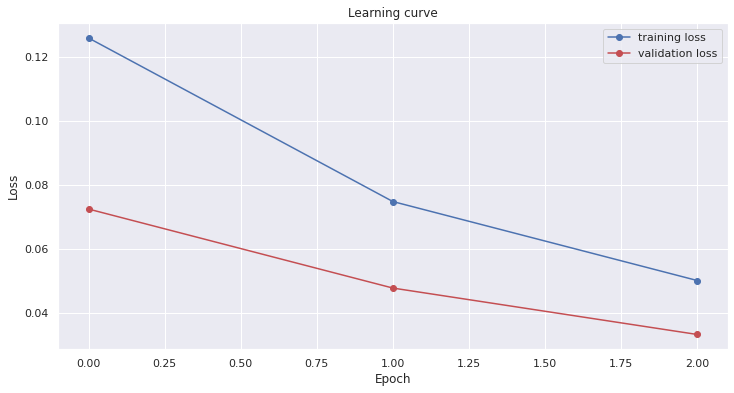

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [50]:
test_sentence = """Mark Elliot Zuckerberg is an American internet entrepreneur. He is known for co-founding the social media website Facebook and its parent company Meta, located in Menlo Park, California."""

In [51]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [52]:
with torch.no_grad():
    output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

In [53]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [54]:
names = []
locs = []
orgs = []

curr_name = ""
curr_loc = ""
curr_org = ""
for i in range(len(new_tokens)):
    if new_labels[i] != 'O':
        leb = new_labels[i]
        if leb == "B-per":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]
        
        
        if leb == "I-per":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]
        
        if leb == "B-geo":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]
        
        if leb == "I-geo":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                orgs.append(curr_org)
                curr_org = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]

        if leb == "B-org":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                curr_org += " "
            curr_org += new_tokens[i]
            
            
          
        if leb == "I-org":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_org != "":
                curr_org += " "
            curr_org += new_tokens[i]  


    else:
        if curr_name != "":
            names.append(curr_name)
            curr_name = ""
        if curr_loc != "":
            locs.append(curr_loc)
            curr_loc = ""
        if curr_org != "":
            orgs.append(curr_org)
            curr_org = ""



df = pd.DataFrame()
df["Free flow of Text"] = [test_sentence]
df["Extracted Name"] = [names]
df["Extracted Location"] = [locs]
df["Extracted Organization"] = [orgs]

print(df)

df.to_csv("output1.csv", index=False)

                                   Free flow of Text  \
0  Mark Elliot Zuckerberg is an American internet...   

             Extracted Name        Extracted Location Extracted Organization  
0  [Mark Elliot Zuckerberg]  [Menlo Park, California]       [Facebook, Meta]  
